In [1]:
import json
import pandas as pd

#open json file
f = open('tweets_DM.json','r',encoding = 'utf-8')

#load data

tweets = []
for line in f.readlines():
    dic = json.loads(line)
    tweets.append(dic)
    
f.close()

In [4]:
import csv
with open('emotion.csv', newline='') as csvfile:

  # 讀取 CSV 檔內容，將每一列轉成一個 dictionary
  rows = csv.DictReader(csvfile)
  label = dict()
  # 以迴圈輸出指定欄位
  for row in rows:
    label[row['tweet_id']] = row['emotion']
    
csvfile.close()

In [5]:
with open('data_identification.csv') as csvfile:

  # 讀取 CSV 檔內容，將每一列轉成一個 dictionary
  rows = csv.DictReader(csvfile)
  identi = dict()
  # 以迴圈輸出指定欄位
  for row in rows:
    identi[row['tweet_id']] = row['identification']
    
csvfile.close()

In [6]:
#seperate trainingset and testing data
trainset = []
testset = []
for i in tweets:
    if identi[i['_source']['tweet']['tweet_id']] == 'train': 
        trainset.append(i)
    else:
        testset.append(i)

In [7]:
#add label in trainset
for data in trainset:
    data['label'] = label[data['_source']['tweet']['tweet_id']] 
    data['hashtag'] = data['_source']['tweet']['hashtags']
    data['text'] =  data['_source']['tweet']['text']
    data['tweet_id'] =  data['_source']['tweet']['tweet_id']

In [8]:
for data in testset:
    data['hashtag'] = data['_source']['tweet']['hashtags']
    data['text'] =  data['_source']['tweet']['text']
    data['tweet_id'] =  data['_source']['tweet']['tweet_id']

In [9]:
#先從trainset 著手

Train = pd.DataFrame.from_dict(trainset)
Test  = pd.DataFrame.from_dict(testset)

In [119]:
#sample data 
Train_sample = Train.sample(n=100000)


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

joy             17839
anticipation     8506
trust            7082
sadness          6660
disgust          4734
fear             2098
surprise         1726
anger            1355
Name: label, dtype: int64


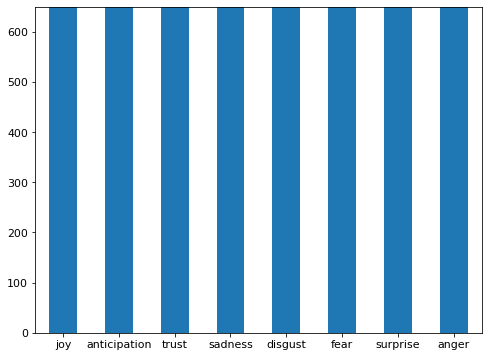

In [12]:
print(Train_sample.label.value_counts())

Train_sample.label.value_counts().plot(kind = 'bar',
                                    ylim = [0, 650],        
                                    rot = 0, fontsize = 11, figsize = (8,6))

In [11]:
#data balance do not do this part
g = Train.groupby('label')
Train_sample = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))

In [12]:
print(len(Train_sample))

318936


In [13]:
#data balance do not do thispart
Train_sample = Train_sample.sample(n=len(Train_sample))

In [14]:
#data balance do not do this part
rint(Train_sample.label.value_counts())

anticipation    39867
trust           39867
joy             39867
surprise        39867
disgust         39867
anger           39867
fear            39867
sadness         39867
Name: label, dtype: int64


In [21]:
import numpy as np
import pandas as pd 


import os

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Embedding,CuDNNLSTM,Bidirectional,Flatten
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [120]:
x = Train_sample['text']
y = Train_sample['label']

In [121]:
from sklearn.preprocessing import LabelEncoder
import keras
label_encoder = LabelEncoder()
label_encoder.fit(y)
def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y = label_encode(label_encoder, y)

In [122]:
token = Tokenizer()
token.fit_on_texts(x)
seq = token.texts_to_sequences(x)

In [123]:
pad_seq = pad_sequences(seq,maxlen=200)

In [124]:
vocab_size = len(token.word_index)+1

In [125]:
X_train, X_test, Y_train, Y_test = train_test_split(pad_seq, y, test_size=0.25)

In [23]:
#need download the glove pre-training embedding
embedding_vector = {}
f = open('glove.twitter.27B.200d.txt','r', encoding="utf-8")
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef

1193514it [01:07, 17684.62it/s]


In [ ]:
embedding_matrix = np.zeros((vocab_size,200))
for word,i in tqdm(token.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

 27%|████████████████████▏                                                     | 34841/127560 [02:41<07:30, 205.85it/s]

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size,200,weights = [embedding_matrix],input_length=200,trainable = False))
model.add(Bidirectional(CuDNNLSTM(75,return_sequences=True)))
model.add(Dropout(0.2))
#model.add(SeqSelfAttention(attention_activation='sigmoid'))
#model.add(Bidirectional(CuDNNLSTM(32,return_sequences=False)))
model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add(Flatten())
model.add(Dense(32,activation = 'relu'))
model.add(Dense(8,activation = 'sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics = ['accuracy'])
history = model.fit(X_train,Y_train,epochs = 5,batch_size=256,validation_split=0.2)

In [102]:
validation_result = model.predict_classes(X_test)

In [103]:
print(validation_result[:10])

[5 5 1 5 7 7 4 5 1 2]


In [104]:
#['anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness' 'surprise'
 #'trust']
    
predict_emotion = []
for i in range(len(validation_result)):
    if validation_result[i] == 0:
        predict_emotion.append('anger')
    if validation_result[i] == 1:
        predict_emotion.append('anticipation')
    if validation_result[i] == 2:
        predict_emotion.append('disgust')
    if validation_result[i] == 3:
        predict_emotion.append('fear')
    if validation_result[i] == 4:
        predict_emotion.append('joy')
    if validation_result[i] == 5:
        predict_emotion.append('sadness') 
    if validation_result[i] == 6:
        predict_emotion.append('surprise')
    if validation_result[i] == 7:
        predict_emotion.append('trust')

In [105]:
Y_test = label_decode(label_encoder, Y_test)

In [106]:
print(predict_emotion[:10])
print(Y_test[:10])

['sadness', 'sadness', 'anticipation', 'sadness', 'trust', 'trust', 'joy', 'sadness', 'anticipation', 'disgust']
['sadness' 'sadness' 'joy' 'sadness' 'trust' 'joy' 'joy' 'disgust' 'trust'
 'anticipation']


In [107]:
import sklearn
sklearn.metrics.f1_score(Y_test, predict_emotion,average='weighted')

0.40207551729862495

In [ ]:
x_test = Test['text']
x_test = token.texts_to_sequences(x_test)
testing_seq = pad_sequences(x_test,maxlen=200)

In [ ]:
predict = model.predict_classes(testing_seq)

In [ ]:
#['anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness' 'surprise'
 #'trust']
predict_emotion = []
for i in range(len(predict)):
    if predict[i] == 0:
        predict_emotion.append('anger')
    if predict[i] == 1:
        predict_emotion.append('anticipation')
    if predict[i] == 2:
        predict_emotion.append('disgust')
    if predict[i] == 3:
        predict_emotion.append('fear')
    if predict[i] == 4:
        predict_emotion.append('joy')
    if predict[i] == 5:
        predict_emotion.append('sadness') 
    if predict[i] == 6:
        predict_emotion.append('surprise')
    if predict[i] == 7:
        predict_emotion.append('trust')
    

In [116]:
predict_emotion[:10]

['anticipation',
 'anticipation',
 'joy',
 'joy',
 'trust',
 'sadness',
 'joy',
 'joy',
 'joy',
 'sadness']

In [117]:
print(len(predict_emotion))

411972


In [118]:
with open('Submission.csv','w',newline = '') as csvfile:
  csvfile.truncate()
  writer = csv.writer(csvfile)

  # 寫入一列資料
  writer.writerow(['id', 'emotion'])

  # 寫入另外幾列資料
  for i in range(len(predict_emotion)):
      writer.writerow([testset[i]['_source']['tweet']['tweet_id'], predict_emotion[i]])
  
    
csvfile.close()